# Importing modules

In [610]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox

pd.options.display.max_rows = 50

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

## Data Cleaning

### loading & exploring Data

In [611]:
re_df = pd.read_excel('Data_MidTerm_Project_Real_State_Regression.xls')

In [612]:
re_df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [613]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

### converting date column

re_df['date'] = re_df['date'].dt.to_period('M')

re_df['date'] = re_df['date'].dt.strftime('%m/%Y')

re_df['date'].value_counts()

In [614]:
#re_df = re_df[re_df.date != "05/2015"]
#re_df = re_df[re_df.date != "01/2015"]

### dropping columns

In [615]:
re_df.drop(['id'],axis=1, inplace=True)
re_df.drop(['date'],axis=1, inplace=True)
re_df.drop(['sqft_above'],axis=1, inplace=True)
re_df.drop(['sqft_lot'],axis=1, inplace=True)
re_df.drop(['yr_renovated'],axis=1, inplace=True)

### creating a new column area

In [616]:
#step 1: zipcodes gruppieren und avg price ausgeben lassen
#step 2: gruppen sortieren nach avg price
    
grouped_zipcodes = re_df.groupby("zipcode")[["price"]].mean().sort_values(by="price", ascending=False)

#step 3: schwellwerte festlegen

very_affordable_area =list(grouped_zipcodes[grouped_zipcodes["price"]< 250000].index)
affordable_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 250000) & (grouped_zipcodes["price"] < 500000)].index)
medium_priced_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 500000) & (grouped_zipcodes["price"]< 750000)].index)
expensive_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 750000) & (grouped_zipcodes["price"]< 1000000)].index)
very_expensive_area =list(grouped_zipcodes[grouped_zipcodes["price"]>=1000000].index)


#step 4: neue column erstellen mit zip code gruppen

area = []

for row in re_df['zipcode']:
    if row in very_affordable_area:
        area.append('very_affordable area')
    elif row in affordable_area:
        area.append('affordable area')
    elif row in medium_priced_area:
        area.append('medium priced area')
    elif row in expensive_area:
        area.append('expensive area')
    elif row in very_expensive_area:
        area.append('very expensive area')

re_df['area'] = area 

In [617]:
#kann gelöscht werden, da sie wahrscheinlich zu stark mit der neuen column ares korreliert

re_df.drop(['zipcode'],axis=1, inplace=True)

### removing duplicates

In [618]:
re_df.drop_duplicates(inplace=True)

### renaming waterfront column features

In [619]:
# nur zur besseren lesbarkeit später

def clean_waterfront(x):
    if x == 0:
        return 'no'
    elif x == 1:
        return 'yes'

In [620]:
re_df["waterfront"] = list(map(clean_waterfront,re_df["waterfront"])) 

### removing outliers

#### bedrooms

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms'>

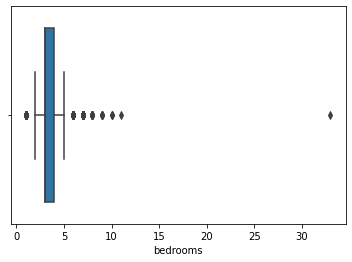

In [621]:
sns.boxplot(re_df['bedrooms'])

In [622]:
max(re_df['bedrooms'])

33

In [623]:
# 22 scheint ein Tippfehler zu sein

re_df.loc[re_df['bedrooms'] == 33]

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,price,area
15856,33,1.75,1620,1.0,no,0,5,7,580,1947,47.6878,-122.331,1330,4700,640000,medium priced area


In [624]:
# deswegen ändern wir diesen wert

re_df.at[15856,'bedrooms'] = 3

#### price

In [625]:
# alle Häuser über 4 Mio. scheinen Außreiser zu sein

re_df = re_df[re_df['price'] < 4000000]

## Export for Tableau

In [626]:
re_df.to_excel(r'cleaned_dataframe.xlsx', index = False)

## Plot the Correlation Heatmap

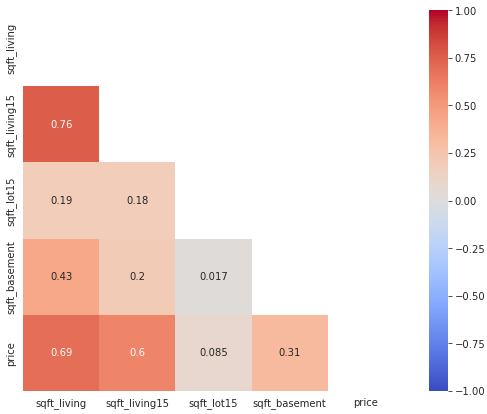

In [627]:
re_num = re_df[['sqft_living','sqft_living15','sqft_lot15','sqft_basement','price']]

corr = re_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## X Y split

In [628]:
X=re_df.drop("price", axis=1)
y=re_df["price"]

## Data Splitting

In [629]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [630]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Data Transformation

### Hot coding Categorical Variables

In [631]:
X_train_cat=X_train[['bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','lat','long','area']]
X_train_cat

X_test_cat=X_test[['bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','lat','long','area']]
X_test_cat

,bedrooms,bathrooms,view,floors,waterfront,condition,grade,yr_built,lat,long,area
12575,2,2.00,0,1.0,no,3,8,2002,47.7103,-122.027,medium priced area
18846,4,3.50,0,2.0,no,3,9,2008,47.6849,-122.327,medium priced area
6912,4,1.00,0,1.5,no,5,7,1951,47.6827,-122.289,medium priced area
18874,5,2.50,0,1.0,no,3,8,1980,47.3429,-122.097,affordable area
7255,3,2.00,0,1.0,no,4,8,1981,47.6231,-122.043,medium priced area
...,...,...,...,...,...,...,...,...,...,...,...
11151,4,2.50,0,2.0,no,3,8,1993,47.6329,-122.021,medium priced area
5863,3,2.25,0,2.0,no,3,7,1986,47.7352,-122.232,affordable area
7135,3,1.75,0,1.0,no,3,7,1950,47.7762,-122.270,affordable area
19081,3,2.75,0,2.0,no,3,8,1999,47.5337,-121.867,medium priced area


In [632]:
X_train_cat=pd.get_dummies(X_train_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_train_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_train_cat).get_feature_names(input_features=X_train_cat.columns))

X_test_cat=pd.get_dummies(X_test_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_test_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_test_cat).get_feature_names(input_features=X_test_cat.columns))

,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.75,bathrooms_1.0,...,long_-121.48,long_-121.473,long_-121.364,long_-121.352,long_-121.316,waterfront_yes_1,area_expensive area_1,area_medium priced area_1,area_very expensive area_1,area_very_affordable area_1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6469,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6470,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6471,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [633]:
X_train_cat = X_train_cat.reset_index(drop=True)
X_test_cat = X_test_cat.reset_index(drop=True)

### Standardize numerical

In [634]:
X_train_num=X_train[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_train_num

X_test_num=X_test[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_test_num

,sqft_living,sqft_living15,sqft_lot15,sqft_basement
12575,2280,2280,6750,0
18846,3130,1830,3900,580
6912,1360,1500,5704,0
18874,2670,1860,35719,1260
7255,1720,1840,10098,580
...,...,...,...,...
11151,2410,2350,7140,0
5863,1180,2660,5979,0
7135,2220,1490,10003,950
19081,1890,2100,4259,0


In [635]:
std_scaler=StandardScaler().fit(X_train_num)   ## finding the parameters (mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train_num)

In [636]:
X_test_scaled=std_scaler.transform(X_test_num)

In [637]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

[[-0.65046398 -0.82870721 -0.19303907  0.25419198]
 [-0.88303878 -0.5217177  -0.27524755 -0.65603394]
 [-0.83873881 -0.97489269 -0.40755733 -0.65603394]
 ...
 [ 0.19123528  0.12149841 -0.18238372  1.09615095]
 [ 1.71958393  2.65050721 -0.01235682 -0.65603394]
 [ 0.40166009 -0.1854911  -0.28759646 -0.65603394]]
--------
[[ 0.22446025  0.42848792 -0.21350298 -0.65603394]
 [ 1.16583442 -0.22934674 -0.31405842  0.66379364]
 [-0.79443885 -0.71175883 -0.25040859 -0.65603394]
 ...
 [ 0.15801031 -0.72637737 -0.09872865  1.50575261]
 [-0.20746437  0.16535405 -0.30139196 -0.65603394]
 [-1.32603838 -0.90179995 -0.27133118 -0.65603394]]


In [638]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train_num.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test_num.columns)

In [639]:
X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)

### Quantile Transformer

In [640]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_living15'] = qt.transform(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_living15'] = qt.transform(X_test_scaled['sqft_living15'].to_numpy().reshape(-1,1))

In [641]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_lot15'] = qt.transform(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_lot15'] = qt.transform(X_test_scaled['sqft_lot15'].to_numpy().reshape(-1,1))

In [642]:
qt = QuantileTransformer(output_distribution="normal").fit(y_train.to_numpy().reshape(-1,1))
y_train = qt.transform(y_train.to_numpy().reshape(-1,1))
y_test = qt.transform(y_test.to_numpy().reshape(-1,1))

## Concatination 

In [643]:
X_train_con=pd.concat([X_train_scaled,X_train_cat],axis=1)
X_test_con=pd.concat([X_test_scaled,X_test_cat],axis=1)

In [644]:
X_train_con

,sqft_living,sqft_living15,sqft_lot15,sqft_basement,bedrooms,bathrooms,view,floors,condition,grade,yr_built,lat,long,waterfront_yes,area_expensive area,area_medium priced area,area_very expensive area,area_very_affordable area
0,-0.650464,-0.837338,-0.097473,0.254192,3,1.50,0,1.0,3,7,1974,47.7148,-122.213,0,0,1,0,0
1,-0.883039,-0.361511,-0.736442,-0.656034,3,1.00,0,1.0,3,6,1958,47.5724,-122.301,0,0,1,0,0
2,-0.838739,-1.090995,-2.148787,-0.656034,2,1.50,0,3.0,3,7,2001,47.6704,-122.390,0,0,1,0,0
3,-0.473264,-0.324254,-1.648444,-0.656034,3,1.75,0,3.0,3,8,2014,47.6638,-122.319,0,1,0,0,0
4,-0.606164,-0.985610,-0.364263,0.276948,3,1.75,0,1.0,3,7,1958,47.5687,-122.397,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15097,0.468110,0.828465,1.505638,0.845839,3,2.00,0,1.0,5,8,1954,47.4468,-122.337,0,0,0,0,0
15098,0.301985,-0.439001,-0.851675,0.732061,3,2.50,0,2.0,3,7,2003,47.6767,-122.365,0,0,1,0,0
15099,0.191235,0.326900,0.014561,1.096151,4,2.75,0,1.0,4,8,1975,47.4449,-122.129,0,0,0,0,0
15100,1.719584,2.091292,1.003934,-0.656034,4,2.75,0,2.0,3,10,1999,47.6378,-122.066,0,0,1,0,0


##  Apply Linear Regression

### Modelling using Statsmodels

In [645]:
X_train_const_scaled = sm.add_constant(X_train_con) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_con) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     3970.
Date:                Thu, 10 Feb 2022   Prob (F-statistic):               0.00
Time:                        15:59:27   Log-Likelihood:                -8248.3
No. Observations:               15102   AIC:                         1.653e+04
Df Residuals:                   15083   BIC:                         1.668e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [646]:
predictions_test

0       0.443633
1       1.024208
2       0.134356
3      -0.632607
4       0.160836
          ...   
6468    0.473815
6469   -0.356917
6470   -0.183951
6471    0.096746
6472   -0.367983
Length: 6473, dtype: float64

In [647]:
#display adjusted R-squared
print(model.rsquared_adj)

0.825526747249154


### Modeling using Scikit Learn

In [648]:
model=LinearRegression()    # model
model.fit(X_train_con, y_train)   # model train

LinearRegression()

In [649]:
model.coef_

array([[ 0.29483854,  0.11063384, -0.02743196, -0.03050207, -0.00399409,
         0.10135436,  0.10709536,  0.04050664,  0.10625192,  0.1961458 ,
        -0.00354514,  1.71798897, -0.22667513,  0.74057758,  0.71409751,
         0.50551601,  1.10538245, -0.3792788 ]])

In [650]:
model.intercept_

array([-104.87131552])

Making prediction

In [651]:
y_pred=model.predict(X_test_con)   # model prediction
##y_pred_train=model.predict(X_train_scaled)

In [652]:
y_test

array([[ 1.17438652],
       [ 1.89525929],
       [ 0.33485067],
       ...,
       [-0.68001258],
       [-0.36151069],
       [-0.23808933]])

In [653]:
y_pred

array([[ 0.4436326 ],
       [ 1.02420816],
       [ 0.13435584],
       ...,
       [-0.18395107],
       [ 0.09674594],
       [-0.36798318]])

In [654]:
y_test = y_test.reshape(len(y_test))
y_pred = y_pred.reshape(len(y_pred))

In [655]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result

,y_test,y_pred
0,1.174387,0.443633
1,1.895259,1.024208
2,0.334851,0.134356
3,-0.193143,-0.632607
4,0.216726,0.160836
...,...,...
6468,0.571145,0.473815
6469,-0.538943,-0.356917
6470,-0.680013,-0.183951
6471,-0.361511,0.096746


Linear Regression Train-test split. Standardize the data (after the data split). Apply linear regression. Model Interpretation. Model Validation Model Evaluation: MSE. RMSE. MAE. R2. Adjusted R2. Feature Importance.

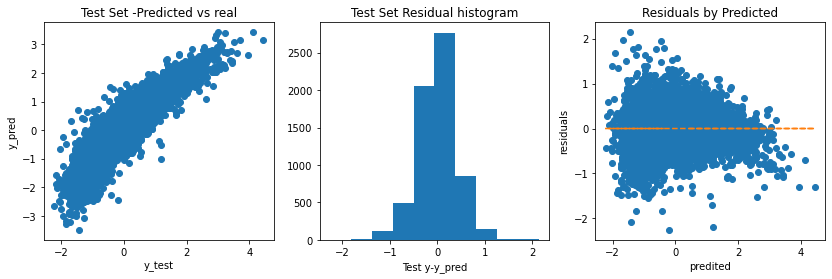

In [656]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

#### Error metrics

In [657]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

0.17485996759597863
0.31372268524348235


In [658]:
R2=r2_score(y_test,y_pred)
R2

0.8264602111850863

In [659]:
X_test.shape[1]

15

In [660]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.8260570678008174

#### Feature Importance

In [661]:
coef = model.coef_.reshape(model.coef_.shape[1])

In [662]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_con.columns,
    'Importance': abs(coef)
})
features_importances = features_importances.sort_values(by='Importance')

In [663]:
features_importances

,Attribute,Importance
10,yr_built,0.003545
4,bedrooms,0.003994
2,sqft_lot15,0.027432
3,sqft_basement,0.030502
7,floors,0.040507
5,bathrooms,0.101354
8,condition,0.106252
6,view,0.107095
1,sqft_living15,0.110634
9,grade,0.196146


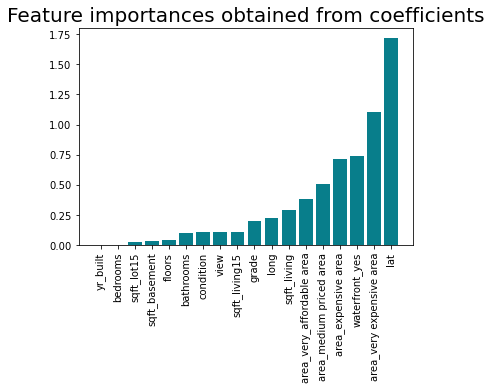

In [664]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Evaluating predictions

In [665]:
# MAE: mean absolute error
MAE = np.mean( np.abs( y_test - y_pred ) )
MAE

0.31372268524348235

In [666]:
# MSE: mean squared error
MSE = np.mean( np.power( y_test - y_pred , 2 ) )
MSE

0.17485996759597863

In [667]:
# RMSE: root mean squared error
RMSE = np.sqrt(MSE)
RMSE

0.41816260903622005

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>],
       [<AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

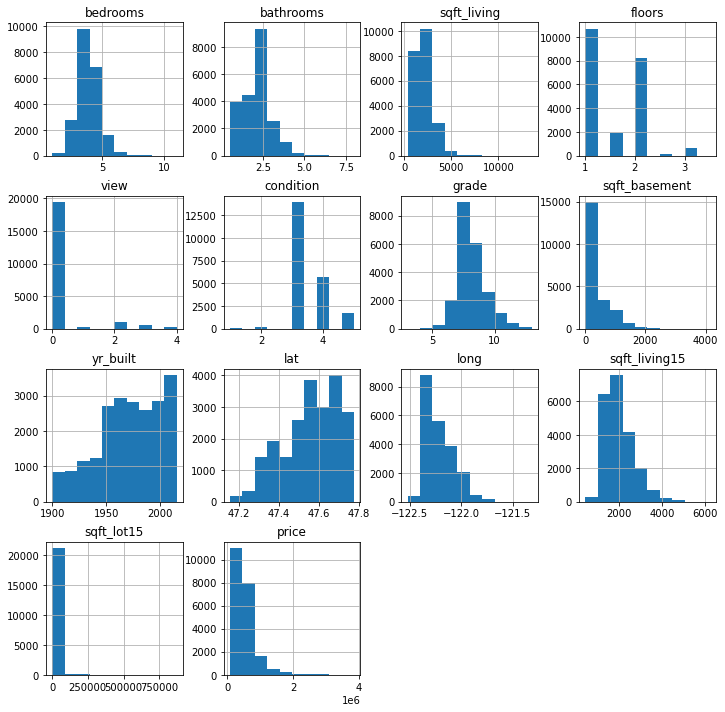

In [668]:
re_df.hist(figsize=(12,12))